# Testing

This notebook assumes you have completed 'train.py' to train your model. Else, please look at that file first.

### Step 1: Run necessary imports

Below are all the modules required for both testing.

In [1]:
# allows python file to be immediately loaded upon edit
%load_ext autoreload
%autoreload 2

In [21]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    LoadImaged,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    EnsureChannelFirstd,
    RandFlipd,
    RandSpatialCropd,
    RandRotated,
    AsDiscrete,
    CropForegroundd,
    Resized,
    Activations,
)
from monai.networks.nets import UNet, SegResNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np
from tqdm import tqdm

from monai.inferers import sliding_window_inference

from grp_transforms import ForceSyncAffined, Roundd, AccumulateOneHot

### Step 2: Define input and output folders

'in_dir' specifies the folder with all the input data to train the model from. If you followed data_preperation.ipynb, it should be the 'task_data' folder.
'model_dir' specifies the folder where all the output after training the model should go, including the actual model itself and any metrics that have been used to quantify the training and testing performance.

In [23]:
in_dir = 'data/task_data'
model_dir = 'data/prev_train_results/unet_1_full_noFlip/' # 'data/task_results'

Set model used

In [24]:
model_type = 'UNet'
device = torch.device("cuda:0")

if model_type == 'SegResNet':
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=1,
        out_channels=3,
        dropout_prob=0.0,
        ).to(device)
    model_dir = os.path.join(model_dir, "segresnet_oh")
    
elif model_type == 'ResUNet':
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=3,
        channels=(16, 32, 64, 128, 256), 
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
        ).to(device)
    model_dir = os.path.join(model_dir, "resunet_oh")

else:            
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=3,
        channels=(16, 32, 64, 128, 256), 
        strides=(2, 2, 2, 2),
        num_res_units=0,
        norm=Norm.BATCH,
        ).to(device)
    model_dir = os.path.join(model_dir, "unet_oh") 

File names for training and testing outputs.

In [25]:
epoch_loss = np.load(os.path.join(model_dir, 'epoch_loss.npy'))
metric_mean = np.load(os.path.join(model_dir, 'metric_mean.npy'))

To check that they are correctly defined, try running the following code.
The code will pull metrics accumulated during the training phase

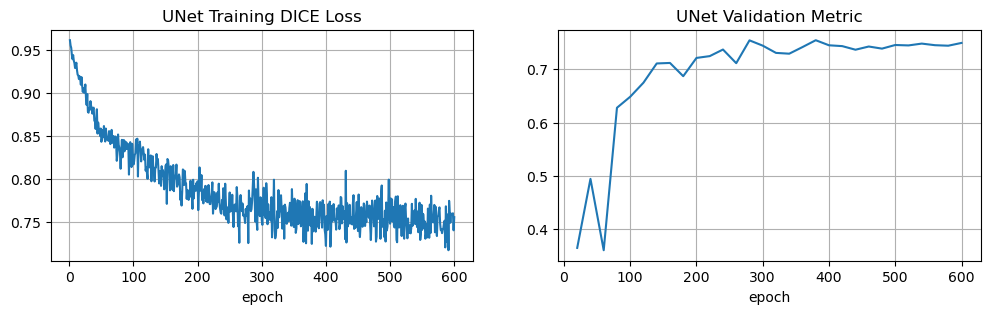

In [26]:
val_interval = 20
max_x = 600

plt.figure("Results 25 june", (12, 3))
plt.subplot(1, 2, 1)
plt.title(f"{model_type} Training DICE Loss")
x = [i + 1 for i in range(min(max_x, len(epoch_loss)))]
y = epoch_loss[:max_x]
plt.xlabel("epoch")
plt.grid()
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title(f"{model_type} Validation Metric")
x = [(i + 1) * val_interval for i in range(min(int(max_x/val_interval), len(metric_mean)))]
y = metric_mean[:int(max_x/val_interval)]
plt.xlabel("epoch")
plt.plot(x, y)
plt.grid()
plt.show()

Folder names for training and testing inputs

In [27]:
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes_full", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainLabels_full", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes_full", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestLabels_full", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files

### Step 3: Run inference using the trained model

Before we can run inference, we need to preprocess the data as per how the original data was preprocessed. Below code defines the preprocessing sequence and must be same as the way it was done during training.

Currently, steps include loading, adding channels, unifying the spacing, orientation and scaling the intesity of ranges of image to be the same. Finally cropping of foreground and resizing of image before converting them into tensors.

Note this is the bare minimum requirements for processing and other methods could and should be used to provide give a better baseline.

In [28]:
a_min = -200
a_max = 200
pixdim=(1.5, 1.5, 1.0)
roi_size=[-1,-1,64]
model_inp_size=[128,128,-1]
randrotate_prob = 0.5
randrotate_xrange = 0.3

In [29]:
train_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        ForceSyncAffined(keys=["seg"], source_key="vol"),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        RandSpatialCropd(keys=["vol", "seg"], roi_size=roi_size, random_size=False),
        Resized(keys=["vol", "seg"], spatial_size=model_inp_size),
        RandFlipd(keys=["vol", "seg"], spatial_axis=0, prob=0.5),
        RandFlipd(keys=["vol", "seg"], spatial_axis=1, prob=0.5),
        RandFlipd(keys=["vol", "seg"], spatial_axis=2, prob=0.5),
        RandRotated(keys=["vol", "seg"], range_x=0.3, prob=0.5),
        Roundd(keys=["seg"]),
        ToTensord(keys=["vol", "seg"]),

        # LoadImaged(keys=["vol", "seg"]),
        # ForceSyncAffined(keys=["seg"], source_key="vol"),
        # EnsureChannelFirstd(keys=["vol", "seg"]),
        # Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        # Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        # RandSpatialCropd(keys=["vol", "seg"], roi_size=roi_size, random_size=False),
        # RandFlipd(keys=["vol", "seg"], spatial_axis=0, prob=0.5),
        # RandFlipd(keys=["vol", "seg"], spatial_axis=1, prob=0.5),
        # RandFlipd(keys=["vol", "seg"], spatial_axis=2, prob=0.5),
        # ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        # ToTensord(keys=["vol", "seg"]),
    ])

val_transforms = Compose([
        LoadImaged(keys=["vol", "seg"]),
        ForceSyncAffined(keys=["seg"], source_key="vol"),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),            
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Resized(keys=["vol", "seg"], spatial_size=model_inp_size),
        Roundd(keys=["seg"]),
        ToTensord(keys=["vol", "seg"]),

        # LoadImaged(keys=["vol", "seg"]),
        # ForceSyncAffined(keys=["seg"], source_key="vol"),
        # EnsureChannelFirstd(keys=["vol", "seg"]),
        # ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),            
        # Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        # CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        # Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        # Resized(keys=["vol", "seg"], spatial_size=(roi_size[0],roi_size[1],-1)),
        # ToTensord(keys=["vol", "seg"]),
    ])

The next step loads the weights into your defined model.

In [30]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): BatchNorm3d(64

Finally, inference and visualization of the data. The below code runs the inference step and visualize the inputs and outputs of the trained model.

{'vol': 'data/task_data/TestVolumes_full/volume-113.nii.gz', 'seg': 'data/task_data/TestLabels_full/segmentation-113.nii.gz'}
torch.Size([1, 1, 128, 128, 669])
torch.Size([1, 1, 128, 128, 669]) torch.Size([1, 1, 128, 128, 669])
1 torch.Size([3, 128, 128, 669]) torch.Size([3, 128, 128, 669])


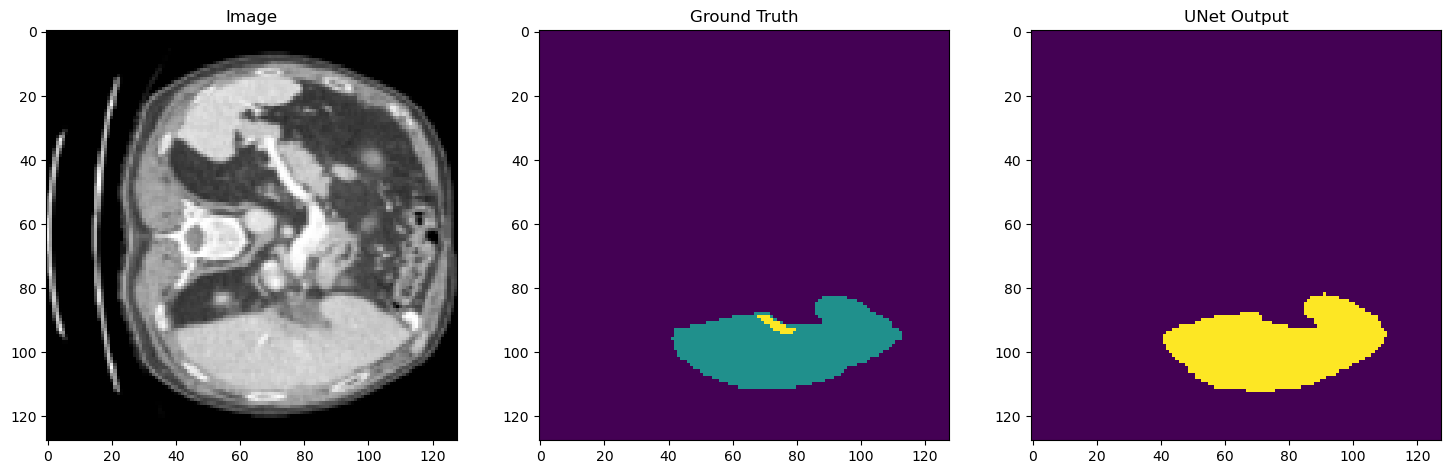

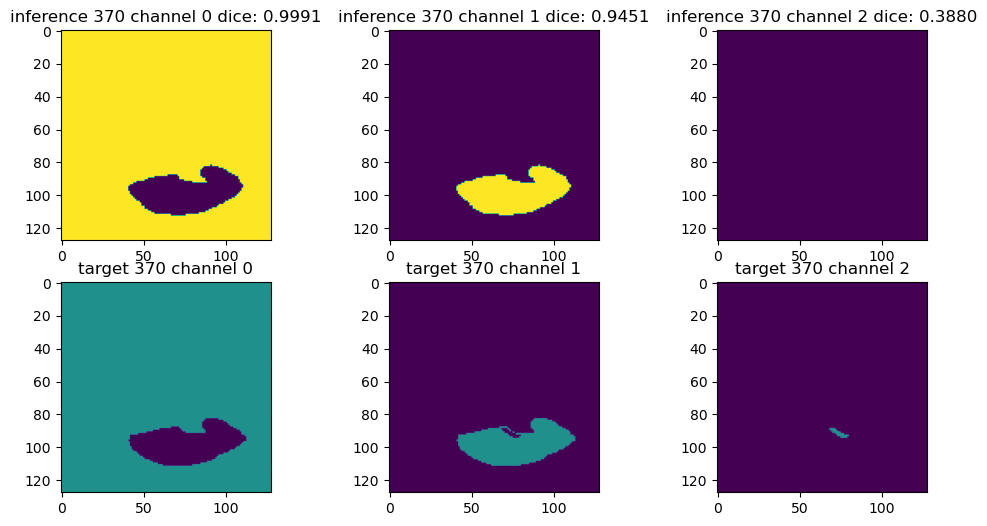

In [45]:
sample_id = 0
print(test_files[sample_id])
test_ds = Dataset(data=test_files[sample_id:sample_id+1], transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

post_trans = Compose(
    [
        Activations(softmax=True),
        # Activations(sigmoid=True),
        AsDiscrete(argmax=True, to_onehot=3),
    ])
pre_trans = Compose([AsDiscrete(to_onehot=3)])

dice_metric_mean_batch = DiceMetric(include_background=True, reduction="mean_batch")
dice_metric_mean = DiceMetric(include_background=True, reduction="mean")

sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    val_data = first(test_loader)
    
    val_volume = val_data["vol"]
    val_label = val_data["seg"]
    print(val_volume.shape)
    val_volume, val_label = (val_volume.to(device), val_label.to(device))
    
    roi_size = (128, 128, 64)
    sw_batch_size = 1

    with torch.cuda.amp.autocast():  
        val_outputs = sliding_window_inference(val_volume, roi_size, sw_batch_size, model, overlap=0.5)

    # Compute each val metrics 
    val_outputs_tf = [post_trans(i) for i in decollate_batch(val_outputs)]
    val_label_tf = [pre_trans(i) for i in decollate_batch(val_label)]
    dice_metric_mean_batch(y_pred=val_outputs_tf, y=val_label_tf)
    dice_metric_mean(y_pred=val_outputs_tf, y=val_label_tf)

    dices = dice_metric_mean_batch.aggregate()
    mean_dice = dice_metric_mean.aggregate().item()

print(val_data["vol"].shape, val_data["seg"].shape)
print(len(val_outputs_tf), val_outputs_tf[0].shape, val_label_tf[0].shape)

window_ind = 0
depth_ind = 370

combined_inference = torch.zeros_like(val_outputs_tf[window_ind][0, ..., depth_ind])
class_one = val_outputs_tf[window_ind][1, ..., depth_ind] == 1
class_two = val_outputs_tf[window_ind][2, ..., depth_ind] == 1
combined_inference[class_one] = 1
combined_inference[class_two] = 2

disp_size = 6
plt.figure("check", (disp_size * 3, disp_size))
plt.subplot(1, 3, 1)
plt.title(f"Image")
plt.imshow(val_data["vol"][0, 0, :, :, depth_ind], cmap="gray")
plt.subplot(1, 3, 2)
plt.title(f"Ground Truth")
plt.imshow(val_data["seg"][0, 0, :, :, depth_ind])
plt.subplot(1, 3, 3)
plt.title(f"{model_type} Output")
plt.imshow(combined_inference.detach().cpu(), vmin=0, vmax=2)

plt.figure("sanity", (disp_size * 2, disp_size))
for i in range(val_outputs_tf[window_ind].shape[0]):
    plt.subplot(2, 3, i+1)
    plt.title(f"inference {depth_ind} channel {i} dice: {dices[i]:.4f}")
    plt.imshow(val_outputs_tf[window_ind][i, ..., depth_ind].detach().cpu())
    plt.subplot(2, 3, i+4)
    plt.title(f"target {depth_ind} channel {i}")
    plt.imshow(val_label_tf[window_ind][i, ..., depth_ind].detach().cpu(), vmin=0, vmax=2)
plt.show()


Evaluate entire validation data set. Extra step: To validate against two class scenario, we accumulate the tumor layer on to the healthy liver layer such that the layer contains both healthy and tumorous liver.

In [31]:
test_ds = Dataset(data=test_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

post_trans = Compose(
    [
        Activations(softmax=True),
        # Activations(sigmoid=True),
        AsDiscrete(argmax=True, to_onehot=3),
        AccumulateOneHot(source_layer=2, target_layer=1)
    ])
pre_trans = Compose(
    [
        AsDiscrete(to_onehot=3),
        AccumulateOneHot(source_layer=2, target_layer=1)
    ])

sw_batch_size = 4
roi_size = (128, 128, 64)

dice_metric_mean_batch = DiceMetric(include_background=True, reduction="mean_batch")
dice_metric_mean = DiceMetric(include_background=True, reduction="mean")
liver_dice, tumor_dice, mean_dice = (0, 0, 0)

with torch.no_grad():
    pbar = tqdm(test_loader)
    for val_data in pbar:
        val_volume = val_data["vol"]
        val_label = val_data["seg"]
        val_volume, val_label = (val_volume.to(device), val_label.to(device))
        
        with torch.cuda.amp.autocast():  
            val_outputs = sliding_window_inference(val_volume, roi_size, sw_batch_size, model, overlap=0.5)

        # Compute each val metrics 
        val_outputs_tf = [post_trans(i) for i in decollate_batch(val_outputs)]
        val_label_tf = [pre_trans(i) for i in decollate_batch(val_label)]
        dice_metric_mean_batch(y_pred=val_outputs_tf, y=val_label_tf)
        dice_metric_mean(y_pred=val_outputs_tf, y=val_label_tf)

        _, liver_dice_i, tumor_dice_i = dice_metric_mean_batch.aggregate()
        liver_dice += liver_dice_i
        tumor_dice += tumor_dice_i
        mean_dice_i = dice_metric_mean.aggregate().item()
        mean_dice += mean_dice_i

        pbar.set_description(f"Liver Dice: {liver_dice_i:.4f}, Tumor Dice: {tumor_dice_i:.4f}, Mean Dice: {mean_dice_i:.4f}")

        
    liver_dice /= len(test_loader)
    tumor_dice /= len(test_loader)
    mean_dice /= len(test_loader)

print(f"Mean Liver Dice: {liver_dice:.4f}, Mean Tumor Dice: {tumor_dice:.4f}, Mean Mean Dice: {mean_dice:.4f}")

Liver Dice: 0.8914, Tumor Dice: 0.3241, Mean Dice: 0.7846:  35%|███▍      | 9/26 [01:01<01:16,  4.49s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-27 20:47:02,152 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Liver Dice: 0.9118, Tumor Dice: 0.3039, Mean Dice: 0.7546: 100%|██████████| 26/26 [03:01<00:00,  6.97s/it]

Mean Liver Dice: 0.9084, Mean Tumor Dice: 0.3213, Mean Mean Dice: 0.7626


## Optional: Visualization of training data transforms

torch.Size([1, 1, 128, 128, 64])


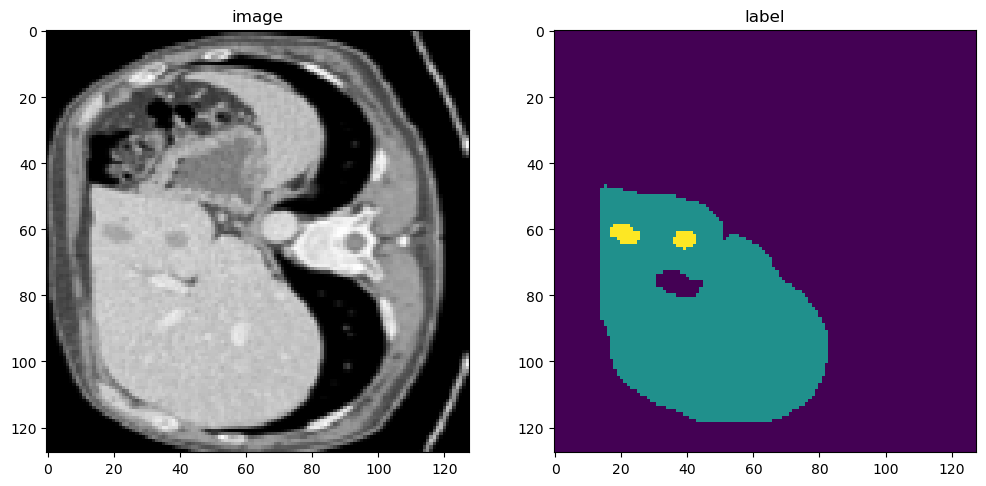

In [158]:
sample_id = 4
train_ds = Dataset(data=train_files[sample_id:sample_id+1], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1)

data_pt = first(train_loader)
print(data_pt["vol"].shape)
depth_ind = 40

disp_size = 6
plt.figure("check", (disp_size * 2, disp_size))
plt.subplot(1, 2, 1)
plt.title(f"image")
plt.imshow(data_pt["vol"][0, 0, :, :, depth_ind], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"label")
plt.imshow(data_pt["seg"][0, 0, :, :, depth_ind])
plt.show()

torch.Size([1, 1, 128, 128, 64])


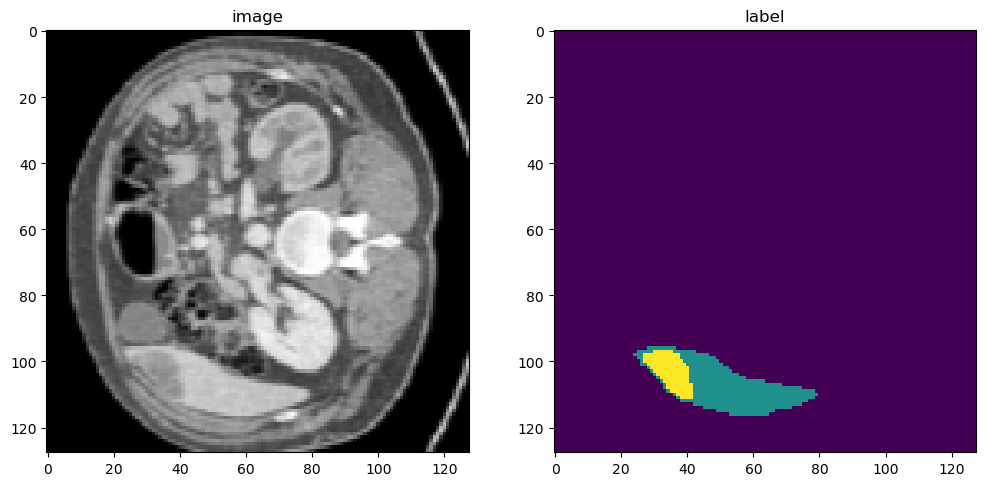

In [159]:
data_pt_2= first(train_loader)
print(data_pt_2["vol"].shape)
depth_ind = 40

disp_size = 6
plt.figure("check", (disp_size * 2, disp_size))
plt.subplot(1, 2, 1)
plt.title(f"image")
plt.imshow(data_pt_2["vol"][0, 0, :, :, depth_ind], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"label")
plt.imshow(data_pt_2["seg"][0, 0, :, :, depth_ind])
plt.show()